In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Flickr_sample/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
##dataloader
## vocab
## create model
## train
## validation
#CUDA_LAUNCH_BLOCKING="1"

In [0]:
import torch
import nltk
import time
import math
nltk.download('punkt')
from imageio import imread
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import copy
from skimage.io import imread
from skimage.transform import resize
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
image_ids = os.listdir('Flicker8k_Dataset')
## lower all the sentences
with open('Flickr8k.token.txt', 'r') as f:
  w = f.readlines()
w_dict = {}
for l in w:
  if l.split('#')[0] in list(w_dict.keys()):
    w_dict[l.split('#')[0]].append(l.split('#')[1][3:-4])
  else:
    w_dict[l.split('#')[0]] = [l.split('#')[1][3:-4]]

image_ids = [ids for ids in image_ids if ids in list(w_dict.keys())]
train_size = 0.8
train_ids = image_ids[:math.floor(len(image_ids)*train_size)]
valid_ids = image_ids[math.floor(len(image_ids)*train_size):]

In [0]:
##vocab
vocab = {}
for li in w_dict.values():
  for sen in li:
    for word in sen.split(' '):
      if word not in vocab:
        vocab[word] = 1
      else:
        vocab[word] += 1
words = [word for word, count in vocab.items() if count >= 5]

In [0]:
class Vocabulary(object):
  def __init__(self):
    self.word2idx = {}
    self.id2word = {}
    self.idx = 0
  
  def add_word(self, word):
    if word not in self.word2idx:
      self.word2idx[word] = self.idx
      self.id2word[self.idx] = word
      self.idx += 1
  
  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx['<unk>']
    return self.word2idx[word]
  
  def __len__(self):
    return len(self.word2idx)

In [0]:
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')
for word in words:
  vocab.add_word(word)

In [0]:
class ImagecaptionDataset(data.Dataset):
  def __init__(self,root,vocab, image_ids, text, transform = None):
    self.image_ids = image_ids
    self.text = text
    self.vocab = vocab
    self.transform = transform
    self.root = root
  def __getitem__(self, index):
    img = self.image_ids[index]
    caption = self.text[img][0]
    image = Image.open(self.root +img).convert('RGB')
    image = image.resize((256, 256))

    if self.transform is not None:
      image = self.transform(image)
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    caption = []
    caption.append(self.vocab('<start>'))
    caption.extend([self.vocab(cap) for cap in tokens])
    caption.append(self.vocab('<end>'))

    target = torch.Tensor(caption)

    return image, target
  
  def __len__(self):
    return len(self.image_ids)

In [0]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    lengths = torch.LongTensor(lengths)
    lengths = lengths.view(-1,1)
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
      end = lengths[i]
      targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [0]:
def get_loader(root, vocab,  image_ids,text, batch_size, shuffle, num_workers, transform):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    flickr = ImagecaptionDataset(root,vocab, image_ids, text, transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=flickr, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class Encoder(nn.Module):

  def __init__(self, encoded_image_size=14):
    
    super(Encoder, self).__init__()
    self.enc_image_size = encoded_image_size

    resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

    # Remove linear and pool layers (since we're not doing classification)
    modules = list(resnet.children())[:-2]
    self.resnet = nn.Sequential(*modules)

    # Resize image to fixed size to allow input images of variable size
    self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    self.fine_tune()

  def forward(self, images):
    """
    Forward propagation.
    :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
    :return: encoded images
    """
    out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
    out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
    out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
    return out

  def fine_tune(self, fine_tune=True):
    """
    Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
    :param fine_tune: Allow?
    """
    for p in self.resnet.parameters():
      p.requires_grad = False
    # If fine-tuning, only fine-tune convolutional blocks 2 through 4
    for c in list(self.resnet.children())[5:]:
      for p in c.parameters():
        p.requires_grad = fine_tune


h_n of shape (num_layers * num_directions, batch, hidden_size)

Attention softmax(Wfull_att(Relu(Wencoder*Hencoder + Wdecoder*Hdecoder))))

In [0]:
class Attention(nn.Module):
  
  def __init__(self, encoder_dim, decoder_dim, attention_dim):
    """
    :param encoder_dim: feature size of encoded images
    :param decoder_dim: size of decoder's RNN
    :param attention_dim: size of the attention network
    """
    super(Attention, self).__init__()
    self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
    self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
    self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

  def forward(self, encoder_out, decoder_hidden):
    """
    Forward propagation.
    :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
    :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
    :return: attention weighted encoding, weights
    """
    att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
    att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
    att = self.full_att(self.relu(att1 +   att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
    alpha = self.softmax(att)  # (batch_size, num_pixels)
    attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

    return attention_weighted_encoding, alpha

Decoder with attention needs (ht-1, context vector(ct), yt-1) ,

Initial hidden state is image encoding converted linearly to the hidden size, 

Imput to LSTM is yt-1 embedding and context vector

In [0]:
class DecoderWithAttention(nn.Module):
  """
  Decoder.
  """

  def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
    """
    :param attention_dim: size of attention network
    :param embed_dim: embedding size
    :param decoder_dim: size of decoder's RNN (hidden size of decoder)
    :param vocab_size: size of vocabulary
    :param encoder_dim: feature size of encoded images
    :param dropout: dropout
    """
    super(DecoderWithAttention, self).__init__()

    self.encoder_dim = encoder_dim
    self.attention_dim = attention_dim
    self.embed_dim = embed_dim
    self.decoder_dim = decoder_dim
    self.vocab_size = vocab_size
    self.dropout = dropout

    self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

    self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
    self.dropout = nn.Dropout(p=self.dropout)
    self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
    self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
    self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
    self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
    self.sigmoid = nn.Sigmoid()
    self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
    self.init_weights()  # initialize some layers with the uniform distribution

  def init_weights(self):
    """
    Initializes some parameters with values from the uniform distribution, for easier convergence.
    """
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.fc.bias.data.fill_(0)
    self.fc.weight.data.uniform_(-0.1, 0.1)

  def load_pretrained_embeddings(self, embeddings):
    """
    Loads embedding layer with pre-trained embeddings.
    :param embeddings: pre-trained embeddings
    """
    self.embedding.weight = nn.Parameter(embeddings)

  def fine_tune_embeddings(self, fine_tune=True):
    """
    Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
    :param fine_tune: Allow?
    """
    for p in self.embedding.parameters():
        p.requires_grad = fine_tune

  def init_hidden_state(self, encoder_out):
    """
    Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
    :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
    :return: hidden state, cell state
    """
    mean_encoder_out = encoder_out.mean(dim=1)
    h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
    c = self.init_c(mean_encoder_out)
    return h, c

  def forward(self, encoder_out, encoded_captions, caption_lengths):
    """
    Forward propagation.
    :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
    :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
    :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
    :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
    """

    batch_size = encoder_out.size(0)
    encoder_dim = encoder_out.size(-1)
    vocab_size = self.vocab_size

    # Flatten image
    encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # Sort input data by decreasing lengths; why? apparent below
    caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
    encoder_out = encoder_out[sort_ind]
    encoded_captions = encoded_captions[sort_ind]
    # Embedding
    embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

    # Initialize LSTM state
    h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

    # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
    # So, decoding lengths are actual lengths - 1
    decode_lengths = (caption_lengths - 1).tolist()
    # Create tensors to hold word predicion scores and alphas
    predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
    alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

    # At each time-step, decode by
    # attention-weighing the encoder's output based on the decoder's previous hidden state output
    # then generate a new word in the decoder with the previous word and the attention weighted encoding
    for t in range(max(decode_lengths)):
        batch_size_t = sum([l > t for l in decode_lengths])
        attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                            h[:batch_size_t])
        gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding
        h, c = self.decode_step(
            torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
            (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
        preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
        predictions[:batch_size_t, t, :] = preds
        alphas[:batch_size_t, t, :] = alpha

    return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [0]:
emb_dim = 256  # dimension of word embeddings
attention_dim = 256  # dimension of attention linear layers
decoder_dim = 256 # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 20  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none
vocab_size = len(vocab)

In [0]:
decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=vocab_size,
                                       dropout=dropout)
decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                      lr=decoder_lr)
encoder = Encoder()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                      lr=encoder_lr) if fine_tune_encoder else None
# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

In [0]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, shrink_factor):
  """
  Shrinks learning rate by a specified factor.
  :param optimizer: optimizer whose learning rate must be shrunk.
  :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
  """

  print("\nDECAYING learning rate.")
  for param_group in optimizer.param_groups:
      param_group['lr'] = param_group['lr'] * shrink_factor
  print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [0]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
  """
  Performs one epoch's training.
  :param train_loader: DataLoader for training data
  :param encoder: encoder model
  :param decoder: decoder model
  :param criterion: loss layer
  :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
  :param decoder_optimizer: optimizer to update decoder's weights
  :param epoch: epoch number
  """

  decoder.train()  # train mode (dropout and batchnorm is used)
  encoder.train()

  batch_time = AverageMeter()  # forward prop. + back prop. time
  data_time = AverageMeter()  # data loading time
  losses = AverageMeter()  # loss (per word decoded)
  #top5accs = AverageMeter()  # top5 accuracy

  start = time.time()
  train_loss = 0
  # Batches
  print("training .............")
  for i, (imgs, caps, caplens) in enumerate(train_loader):
    data_time.update(time.time() - start)
    # Move to GPU, if available
    imgs = imgs.to(device)
    caps = caps.to(device)
    caplens = caplens.to(device)
    # if i % 40 == 0:
    #   print(i)
    # Forward prop.
    imgs = encoder(imgs)
    scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

    # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
    targets = caps_sorted[:, 1:]

    # Remove timesteps that we didn't decode at, or are pads
    # pack_padded_sequence is an easy trick to do this
    scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
    targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]
    loss = criterion(scores, targets)

    loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

    # Back prop.
    decoder_optimizer.zero_grad()
    if encoder_optimizer is not None:
      encoder_optimizer.zero_grad()
    loss.backward()

    # Update weights
    decoder_optimizer.step()
    if encoder_optimizer is not None:
      encoder_optimizer.step()
    train_loss += loss.item()
    # Keep track of metrics
    #top5 = accuracy(scores, targets, 5)
    losses.update(loss.item(), sum(decode_lengths))
    #top5accs.update(top5, sum(decode_lengths))
    batch_time.update(time.time() - start)

    start = time.time()

  
  print('Epoch:   ' + str(epoch) + '        train_loss:    ' + str(np.exp(train_loss/i)))
  

In [0]:
def validate(val_loader, encoder, decoder, criterion):
  """
  Performs one epoch's validation.
  :param val_loader: DataLoader for validation data.
  :param encoder: encoder model
  :param decoder: decoder model
  :param criterion: loss layer
  :return: BLEU-4 score
  """
  decoder.eval()  # eval mode (no dropout or batchnorm)
  if encoder is not None:
    encoder.eval()

  batch_time = AverageMeter()
  losses = AverageMeter()

  start = time.time()

  hypotheses = list()  # hypotheses (predictions)

  print('Validation...........................')
  valid_loss = 0
  with torch.no_grad():
    # Batches
    for i, (imgs, caps, caplens) in enumerate(val_loader):
      # Move to device, if available
      imgs = imgs.to(device)
      caps = caps.to(device)
      caplens = caplens.to(device)
      # Forward prop.
      if encoder is not None:
        imgs = encoder(imgs)
      scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

      # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
      targets = caps_sorted[:, 1:]

      # Remove timesteps that we didn't decode at, or are pads
      # pack_padded_sequence is an easy trick to do this
      scores_copy = scores.clone()
      scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
      targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

      loss = criterion(scores, targets)
      loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
      valid_loss += loss.item()
      # Keep track of metrics
      losses.update(loss.item(), sum(decode_lengths))
      #top5 = accuracy(scores, targets, 5)
      #top5accs.update(top5, sum(decode_lengths))
      batch_time.update(time.time() - start)

      start = time.time()
      #if i % print_freq == 0:
    print('Epoch:   ' + str(epoch) + '        valid_loss:    ' + str(np.exp(valid_loss/i)))

  return loss



In [0]:
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))])

root = 'Flicker8k_Dataset/'
train_loader = get_loader(root, vocab,  train_ids,w_dict, batch_size, True,1, transform = transform) 
val_loader = get_loader(root, vocab,  valid_ids,w_dict, batch_size, True,1, transform = transform)
for epoch in range(start_epoch, epochs):

# Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
  if epochs_since_improvement == 20:
    break
  if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
    adjust_learning_rate(decoder_optimizer, 0.8)
    if fine_tune_encoder:
        adjust_learning_rate(encoder_optimizer, 0.8)

  # One epoch's training
  train(train_loader=train_loader,
        encoder=encoder,
        decoder=decoder,
        criterion=criterion,
        encoder_optimizer=encoder_optimizer,
        decoder_optimizer=decoder_optimizer,
        epoch=epoch)
  loss = validate(val_loader=val_loader,
                          encoder=encoder,
                          decoder=decoder,
                          criterion=criterion)



training .............
Epoch:   0        train_loss:    596.4993678583515
Validation...........................
Epoch:   0        valid_loss:    308.58722938614443
training .............
Epoch:   1        train_loss:    246.03955406593332
Validation...........................
Epoch:   1        valid_loss:    185.08834011692076
training .............
Epoch:   2        train_loss:    162.6110014843799
Validation...........................
Epoch:   2        valid_loss:    144.2520557630922
training .............
Epoch:   3        train_loss:    127.83559014322853
Validation...........................
Epoch:   3        valid_loss:    124.87346913406536
training .............
Epoch:   4        train_loss:    109.45725409142594
Validation...........................
Epoch:   4        valid_loss:    112.81210295378857
training .............
Epoch:   5        train_loss:    96.39987907884559
Validation...........................
Epoch:   5        valid_loss:    104.6249151357931
training ......

In [0]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.
    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    #img = resize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas



In [0]:
model_save_name = 'Encoder_att.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(encoder.state_dict(), path)
model_save_name_1 = 'Decoder_att.pt'
path = F"/content/drive/My Drive/{model_save_name_1}" 
torch.save(decoder.state_dict(), path)

In [0]:
encoder = Encoder().to(device)
encoder.eval()
decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=vocab_size,
                                       dropout=dropout).to(device)
decoder.eval()
encoder.load_state_dict(torch.load("/content/drive/My Drive/Encoder_att.pt"))
decoder.load_state_dict(torch.load("/content/drive/My Drive/Decoder_att.pt"))

<All keys matched successfully>

man in a red helmet is riding a bike on a dirt pat


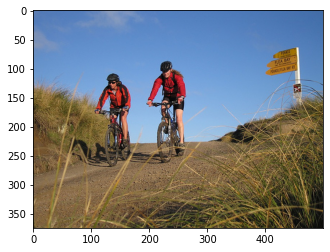

In [0]:
root = 'Flicker8k_Dataset/'
idx = 10
img = plt.imread(root+image_ids[idx])
plt.imshow(img)
s, a = caption_image_beam_search(encoder, decoder, root+image_ids[idx], vocab.word2idx,beam_size=1)
wds = []
for id_ in s:
  if vocab.id2word[id_] != "<start>" and vocab.id2word[id_] != "<end>":
    wds.append(vocab.id2word[id_])
print(' '.join(wd for wd in wds))